## MODELING

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, plot_confusion_matrix  
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.metrics import auc, multilabel_confusion_matrix, plot_roc_curve

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OrdinalEncoder

from sklearn.compose import ColumnTransformer
from sklearn.impute import MissingIndicator, SimpleImputer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter

%matplotlib inline

In [61]:
#importing data
water_pump = pd.read_csv('Data/cleaned_water_pump.csv')
water_pump.head()

,status_group,amount_tsh,gps_height,basin,region,region_code,lga,public_meeting,scheme_management,permit,...,management_group,payment,quality_group,quantity,source,source_class,waterpoint_type,water_per_person,unknown_construction_yr,age_at_inspection
0,functional,6000.0,1390,Lake Nyasa,Iringa,11,Ludewa,True,VWC,False,...,user-group,pay annually,good,enough,spring,groundwater,communal standpipe,55.045872,False,12.0
1,functional,0.0,1399,Lake Victoria,Mara,20,Serengeti,Unknown,Other,True,...,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,0.000000,False,3.0
2,functional,25.0,686,Pangani,Manyara,21,Simanjiro,True,VWC,True,...,user-group,pay per bucket,good,enough,dam,surface,communal standpipe multiple,0.100000,False,4.0
3,non functional,0.0,263,Ruvuma / Southern Coast,Mtwara,90,Nanyumbu,True,VWC,True,...,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,0.000000,False,27.0
4,functional,0.0,0,Lake Victoria,Kagera,18,Karagwe,True,Unknown,True,...,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,NaN,True,NaN


In [62]:
#changing region_code to str
water_pump['region_code'] = water_pump['region_code'].astype('str')

In [63]:
water_pump.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   status_group             59400 non-null  object 
 1   amount_tsh               59400 non-null  float64
 2   gps_height               59400 non-null  int64  
 3   basin                    59400 non-null  object 
 4   region                   59400 non-null  object 
 5   region_code              59400 non-null  object 
 6   lga                      59400 non-null  object 
 7   public_meeting           59400 non-null  object 
 8   scheme_management        59400 non-null  object 
 9   permit                   59400 non-null  object 
 10  extraction_type_group    59400 non-null  object 
 11  extraction_type_class    59400 non-null  object 
 12  management               59400 non-null  object 
 13  management_group         59400 non-null  object 
 14  payment               

In [64]:
#checking target variables
water_pump['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [65]:
#encoding target variables 
le = LabelEncoder()
water_pump["status_group"] = le.fit_transform(water_pump["status_group"])

In [66]:
#verifying what each class refers to 0 - functional, 2 - nonfunctional, 1 - functional needs repair
water_pump['status_group'].value_counts(normalize=True)

0    0.543081
2    0.384242
1    0.072677
Name: status_group, dtype: float64

## Setting up pipeline and functions
Setting up our Pipeline and functions. We have two separate Pipelines. Our first Pipeline uses a Standard Scaler. We used this Pipeline for our Baseline, Logistical, Decision Tree, and Random Forest Models. Our second Pipeline was used for our KNN models. That Pipeline uses a MinMaxScaler. 


In [67]:
#function from lecture
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [68]:
#Train Test Split
X = water_pump.drop('status_group', axis=1)
y = water_pump['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [69]:
#Setting up Data for encoding within both Pipelines
numeric_cols = ["amount_tsh", "gps_height", "age_at_inspection", "water_per_person"]

cat_cols =["basin", "region", "region_code", "lga", "public_meeting", "scheme_management", "permit",
          "extraction_type_group", "extraction_type_class", "management", "management_group", "payment", "quality_group",
          "quantity", "source", "source_class", "waterpoint_type"]
bool_cols = ["unknown_construction_yr"]

In [98]:
#subpipes for Pipeline 1. #using the mean for the imputer
subpipe_num = Pipeline(steps=[("num_impute", SimpleImputer(strategy="mean")),("ss", StandardScaler())])
subpipe_cat = Pipeline(steps=[("ohe", OneHotEncoder(sparse=False, handle_unknown="ignore"))])
subpipe_ord = Pipeline(steps= [("ord_encode", OrdinalEncoder())])

In [99]:
#subpipes for Pipeline 2
subpipe_num2 = Pipeline(steps=[("num_impute", SimpleImputer(strategy="median")),("mm", MinMaxScaler())])
subpipe_cat2 = Pipeline(steps=[("ohe", OneHotEncoder(sparse=False, handle_unknown="ignore"))])
subpipe_ord2 = Pipeline(steps= [("ord_encode", OrdinalEncoder())])

In [100]:
#Column Transformers
CT = ColumnTransformer(transformers=[
                                    ("subpipe_num", subpipe_num, numeric_cols), 
                                     ("subpipe_cat", subpipe_cat, cat_cols),
                                    ("subpipe_ord", subpipe_ord, bool_cols)
                                    ], 
                       remainder="drop"
                      )

In [101]:
#Column Transformers
CT2 = ColumnTransformer(transformers=[
                                    ("subpipe_num2", subpipe_num2, numeric_cols), 
                                     ("subpipe_cat2", subpipe_cat2, cat_cols),
                                    ("subpipe_ord2", subpipe_ord2, bool_cols)
                                    ], 
                       remainder="drop"
                      )

## MODELS
We took an iterative process - we first created a Baseline Model. Then we created several more models - a Logistical, a KNN, a Decision Tree, and a RandomForest Model. We than evaluated each based on two metrics - accuracy and precision. We compared each of these models to the Baseline model. 

####  Model 1- Baseline Model (Dummy Model)
- shouldn't it be predicting that everything is the 0/functional? Dont think that is happening.

In [74]:
dummy_model_pipe = Pipeline(steps=[('ct', CT), ('dum', 
                                                DummyClassifier(strategy="most_frequent",random_state=42))])

In [75]:
dummy_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [76]:
dummy_model_pipe.score(X_train, y_train)

0.542334455667789

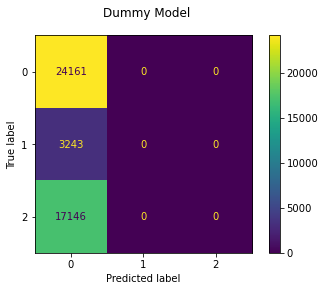

In [77]:
fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

#Plot confusion matrix
plot_confusion_matrix(dummy_model_pipe, X_train, y_train, ax =ax);

In [78]:
dummy_y_pred = dummy_model_pipe.predict(X_test)

In [79]:
print(classification_report(y_test, dummy_y_pred, zero_division=1));

              precision    recall  f1-score   support

           0       0.55      1.00      0.71      8098
           1       1.00      0.00      0.00      1074
           2       1.00      0.00      0.00      5678

    accuracy                           0.55     14850
   macro avg       0.85      0.33      0.24     14850
weighted avg       0.75      0.55      0.38     14850



In [80]:
confusion_matrix(y_test, dummy_y_pred)

array([[8098,    0,    0],
       [1074,    0,    0],
       [5678,    0,    0]])

####  Model 2 - Logistic Regression Model 

In [50]:
log_model_pipe = Pipeline(steps=[('ct', CT), 
                                    ('log', LogisticRegression(random_state=42, max_iter=1000))])

In [51]:
log_model_pipe.fit(X_train, y_train)
log_model_pipe.score(X_train, y_train)

0.7508641975308642

In [52]:
log_y_pred = log_model_pipe.predict(X_test)
print(classification_report(y_test, log_y_pred));

              precision    recall  f1-score   support

           0       0.74      0.89      0.80      8098
           1       0.51      0.12      0.20      1074
           2       0.78      0.66      0.72      5678

    accuracy                           0.75     14850
   macro avg       0.68      0.56      0.57     14850
weighted avg       0.74      0.75      0.73     14850



####  Model 3 - K Nearest Neighbors Model 

In [102]:
knneighbors_model_pipe = Pipeline(steps=[('ct', CT2), ('knn', KNeighborsClassifier(
    metric='manhattan', n_neighbors=5, weights='distance'))])

In [103]:
knneighbors_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num2',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('mm',
                                                                   MinMaxScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat2',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),


In [104]:
knneighbors_model_pipe.score(X_train, y_train)

0.9350392817059484

In [105]:
knn_y_pred = knneighbors_model_pipe.predict(X_test)
print(classification_report(y_test, knn_y_pred));

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      8098
           1       0.41      0.38      0.39      1074
           2       0.79      0.74      0.76      5678

    accuracy                           0.76     14850
   macro avg       0.66      0.65      0.66     14850
weighted avg       0.76      0.76      0.76     14850



####  Model 4 - Decision Tree Model 
?? whats going DT?

In [93]:
dct_model_pipe = Pipeline(steps=[('ct', CT), ('Dct', DecisionTreeClassifier(
    class_weight='balanced', criterion='entropy', min_impurity_decrease=2))])

In [94]:
dct_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [95]:
dct_model_pipe.score(X_train, y_train)

0.3848709315375982

In [96]:
dct_y_pred = dct_model_pipe.predict(X_test)
print(classification_report(y_test, dct_y_pred, zero_division=1 ));

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      8098
           1       1.00      0.00      0.00      1074
           2       0.38      1.00      0.55      5678

    accuracy                           0.38     14850
   macro avg       0.79      0.33      0.18     14850
weighted avg       0.76      0.38      0.21     14850



####  Model 5 - Random Forest Model 

In [149]:
rfc_model_pipe = Pipeline(steps=[('ct', CT), ('rfc', RandomForestClassifier(random_state=42))])

In [150]:
rfc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [151]:
rfc_model_pipe.score(X_train, y_train)

0.9418630751964086

In [152]:
rfc_y_preds = rfc_model_pipe.predict(X_test)

print(classification_report(y_test, rfc_y_preds))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      8098
           1       0.46      0.36      0.40      1074
           2       0.81      0.75      0.78      5678

    accuracy                           0.78     14850
   macro avg       0.69      0.66      0.67     14850
weighted avg       0.78      0.78      0.78     14850



### Comparison of First 5 Models

### WORDS

<img src='images/Model_Results.png' width=100%/>

## GridSearch and Model Optimization
We decided that the Logistical Model didnt do much better than our Dummy Model. While precison was high for our repair pump class - the recall was very low. The f1 score was the lowest - so we turned our attention to our other models. We feel that we can get better metrics. So we decided to run several GridSearches to find the optimal hyperparameters for our KNN, Decision Tree, and RandomForest Models. 

####  Model 6 - Optimized KNN Model 

In [123]:
knneighbors_model_pipe = Pipeline(steps=[('ct', CT2), ('knn', KNeighborsClassifier())])

In [ ]:
knn_pipe_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17], 
    'knn__metric': ['minkowski', 'manhattan', 'euclidean'],
    'knn__weights': ['uniform', 'distance']

}


knn_gs_pipe = GridSearchCV(estimator=knneighbors_model_pipe, param_grid=knn_pipe_grid)

<img src='images/KNN_Gridsearch.png' width=100%/>

In [128]:
optimal_knneighbors_model_pipe = Pipeline(steps=[('ct', CT2), ('knn', KNeighborsClassifier(
              metric='manhattan', n_neighbors=17, weights='distance'))])

In [129]:
optimal_knneighbors_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num2',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('mm',
                                                                   MinMaxScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat2',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),


In [130]:
optimal_knneighbors_model_pipe.score(X_train, y_train)

0.9412121212121212

In [131]:
opt_knn_y_preds = optimal_knneighbors_model_pipe.predict(X_test)

print(classification_report(y_test, opt_knn_y_preds))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      8098
           1       0.47      0.35      0.40      1074
           2       0.80      0.74      0.77      5678

    accuracy                           0.77     14850
   macro avg       0.68      0.65      0.66     14850
weighted avg       0.77      0.77      0.77     14850



####  Model 7 - Optimized Decision Tree Model 

In [ ]:
dct_model_pipe = Pipeline(steps=[('ct', CT), ('dct', DecisionTreeClassifier(random_state=42))])

In [ ]:
pipe_grid_dt = {
    'dt__criterion': ['gini', 'entropy', 'log_loss'], 
    'dt__class_weight': ['None', 'balanced'],
    'dt__min_impurity_decrease': [0.15, 0.2, 0.3]

}


gs_pipe_dt = GridSearchCV(estimator=dt_model_pipe, param_grid=pipe_grid_dt)

<img src='images/DCT_Gridsearch.png' width=100%/>

In [132]:
optimal_dct_model_pipe = Pipeline(steps=[('ct', CT), ('Dct', DecisionTreeClassifier(
    class_weight=None, criterion='gini', min_impurity_decrease=0.15))])

In [133]:
optimal_dct_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [134]:
optimal_dct_model_pipe.score(X_train, y_train)

0.542334455667789

In [135]:
opt_dct_y_pred = optimal_dct_model_pipe.predict(X_test)
print(classification_report(y_test, opt_dct_y_pred, zero_division=1 ));

              precision    recall  f1-score   support

           0       0.55      1.00      0.71      8098
           1       1.00      0.00      0.00      1074
           2       1.00      0.00      0.00      5678

    accuracy                           0.55     14850
   macro avg       0.85      0.33      0.24     14850
weighted avg       0.75      0.55      0.38     14850



####  Model 8 - Optimized Random Forest Model 

In [ ]:
rfc_model_pipe = Pipeline(steps=[('ct', CT), ('rfc', RandomForestClassifier(random_state=42))])

In [ ]:
pipe_grid_rfc = { 
    'rfc__criterion': ['gini', 'entropy'],
    'rfc__min_samples_leaf': [5, 10, 30],
    'rfc__n_estimators': [50, 100, 150],
}

gs_pipe_rfc = GridSearchCV(estimator = rfc_model_pipe, param_grid=pipe_grid_rfc)

<img src='images/RFC_Gridsearch1.png' width=100%/>

In [145]:
optimal_rfc_model_pipe = Pipeline(steps=[('ct', CT), ('rfc', RandomForestClassifier(random_state=42, 
                                criterion='gini', min_samples_leaf=5, n_estimators=100))])

In [146]:
optimal_rfc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [147]:
optimal_rfc_model_pipe.score(X_train, y_train)

0.8051851851851852

In [148]:
opt_rfc_y_pred = optimal_rfc_model_pipe.predict(X_test)
print(classification_report(y_test, opt_rfc_y_pred));

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      8098
           1       0.65      0.19      0.29      1074
           2       0.84      0.70      0.76      5678

    accuracy                           0.78     14850
   macro avg       0.75      0.60      0.63     14850
weighted avg       0.78      0.78      0.77     14850



#### Optimal Model Comparisons

<img src='images/Optimal_Model_Results.png' width=100%/>

## Model Analysis

Taking a look at our results - between our optimal KNN and Random Forest Models - we have pretty good scores on predicting which pumps are nonfunctional or functional (precision scores of 79% - KNN, and 81%(nonfunctional) and 80%(functional) for RFC.  

Our models dont have a really high precison score in our class (1) of interest - so when we predict a pump is in need of repair - we are only accurate 47%(KNN) or 65% (RFC) of the time. We also see that recall scores for our target class is pretty bad - meaning both models arent doing a great job at finding the pumps that are in need of repair - our KNN model is 35% which is better than the Random Forest model's recall score of 19%.

Overall our models arent doing a great job when it comes to predicting pumps in need of repair. We arent giving it enough information. This is probably due to the class imbalance we see in our target. only 7% of pumps are in need of repair compared to 54% (functioning) and 39%(nonfuctioning). Our next step is do try smoting the data to increase this minority class.


# Start editing from here


In [ ]:
error message to mark place

In [163]:
optimal_rfc_model_pipe.named_steps["ct"].named_transformers_["subpipe_cat"]

Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [164]:
optimal_rfc_model_pipe.named_steps["ct"].named_transformers_["subpipe_cat"].named_steps["ohe"]

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [165]:
cat_features_list = list(optimal_rfc_model_pipe.named_steps["ct"].named_transformers_["subpipe_cat"].named_steps["ohe"].get_feature_names())


In [166]:
X_train.head()

,amount_tsh,gps_height,basin,region,region_code,lga,public_meeting,scheme_management,permit,extraction_type_group,...,management_group,payment,quality_group,quantity,source,source_class,waterpoint_type,water_per_person,unknown_construction_yr,age_at_inspection
24947,20.0,330,Wami / Ruvu,Pwani,6,Bagamoyo,True,VWC,True,submersible,...,user-group,pay per bucket,salty,insufficient,machine dbh,groundwater,communal standpipe,0.25,False,39.0
22630,0.0,0,Lake Victoria,Mwanza,17,Magu,Unknown,WUG,False,nira/tanira,...,user-group,unknown,good,enough,shallow well,groundwater,hand pump,NaN,True,NaN
13789,0.0,0,Lake Victoria,Mwanza,19,Kwimba,True,VWC,True,india mark ii,...,user-group,never pay,good,enough,machine dbh,groundwater,hand pump,NaN,True,NaN
15697,0.0,1542,Internal,Singida,13,Singida Urban,True,WUA,True,gravity,...,user-group,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,0.00,False,3.0
22613,0.0,523,Lake Nyasa,Ruvuma,10,Mbinga,Unknown,VWC,True,gravity,...,user-group,unknown,good,dry,spring,groundwater,communal standpipe,0.00,False,0.0


In [167]:
features_names = ["amount_tsh", "gps_height"] + cat_features_list + ["water_per_person", "unknown_construction_yr", "age_at_inspection"]

In [168]:
rfc_importances = optimal_rfc_model_pipe.named_steps["rfc"].feature_importances_

In [169]:
optimal_rfc_model_feature_importance_dict = dict(zip(features_names, rfc_importances)) 

In [170]:
sort_feature_importance = sorted(optimal_rfc_model_feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

for i in sort_feature_importance:
    print(i[0], i[1])

x13_insufficient 0.14027828804465312
x0_Internal 0.057160681954456206
unknown_construction_yr 0.04565125216095784
x13_seasonal 0.041893955617869655
gps_height 0.037568398243498974
x8_submersible 0.0371984312324623
x7_other motorpump 0.03528754611593883
amount_tsh 0.030390615163535174
x0_Lake Nyasa 0.02677327859923114
x16_dam 0.017414148876290045
x13_unknown 0.016381528557518357
x11_pay annually 0.015892779924744246
x13_enough 0.013844224234665217
x8_other 0.012956781291852182
x7_india mark iii 0.012157186023959442
x16_hand pump 0.011442730226705191
x16_other 0.010415392092595913
x9_water board 0.008819699641442094
x15_groundwater 0.008808281986173505
x7_other handpump 0.008114562655105274
x11_unknown 0.007777268572419805
x2_13 0.007407089676433712
x14_unknown 0.007256007476073383
x8_motorpump 0.007056124127864869
x5_WUG 0.0068832860344387415
x7_afridev 0.006827096711604138
x1_Kigoma 0.006564751061853383
x6_Unknown 0.0063321936871662465
x16_cattle trough 0.006209891029728323
x15_unknown

## Using Smote


description

In [147]:
# Check the class distribution of the target
counter = Counter(y_train)
print(counter)

Counter({0: 24161, 2: 17146, 1: 3243})


In [148]:
# Create the oversampler and undersampler objects
over = SMOTE(sampling_strategy="minority", random_state=42)
under = RandomUnderSampler(sampling_strategy="not minority", random_state=42)

## Optimal Random Forest with oversamping Minority and undersampling Majority Classes

In [179]:
imbal_rf_pipe = imbPipeline(steps=[('ct', CT), ("over", over),
                                ("under", under), 
                             ('rfc_model', RandomForestClassifier(random_state=42))])

NameError: name 'imbPipeline' is not defined

In [159]:
rfc_over_under_smote_model_pipe.fit(X_train, y_train)

NameError: name 'rfc_over_under_smote_model_pipe' is not defined

In [ ]:
rfc_over_under_smote_model_pipe.score(X_train, y_train)

In [ ]:
rfc_over_under_smote_y_pred = rfc_over_under_smote_model_pipe.predict(X_test)
print(classification_report(y_test, rfc_over_under_smote_y_pred ));

## Optimal Random Forest with oversamping Minority

In [180]:
rfc_over_smote_model_pipe = imbPipeline(steps=[('ct', CT), ("over", over), ('rfc', 
                                     RandomForestClassifier(criterion= "gini", min_samples_split=6, 
                                                            n_estimators=150, random_state=42))])

NameError: name 'imbPipeline' is not defined

In [153]:
rfc_over_smote_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [156]:
rfc_over_smote_model_pipe.score(X_train, y_train)

0.8786307519640852

In [157]:
rfc_over_smote_y_pred = rfc_over_smote_model_pipe.predict(X_test)
print(classification_report(y_test, rfc_over_smote_y_pred ));

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      8098
           1       0.32      0.53      0.40      1074
           2       0.83      0.73      0.78      5678

    accuracy                           0.76     14850
   macro avg       0.65      0.69      0.66     14850
weighted avg       0.78      0.76      0.77     14850



In [189]:
counter = Counter(y_train)
print(counter)

Counter({0: 24161, 2: 17146, 1: 3243})


In [190]:
strategy = {0:24128, 2:17150., 1:6542}
oversample = SMOTE(sampling_strategy=strategy)


In [ ]:
over = SMOTE(sampling_strategy="strategy", random_state=42)

In [192]:
imbal_knn_pipe = imbPipeline(steps=[('ct', CT), ("over", over), 
                ('knn', KNeighborsClassifier(metric='manhattan', 
                n_neighbors=17, weights='distance'))])


In [193]:
imbal_knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [194]:
imbal_knn_pipe.score(X_train, y_train)

0.9407856341189674

In [195]:
imbal_knn_y_pred = imbal_knn_pipe. predict(X_test)
print(classification_report(y_test, imbal_knn_y_pred));

              precision    recall  f1-score   support

           0       0.79      0.82      0.81      8098
           1       0.33      0.48      0.39      1074
           2       0.82      0.71      0.76      5678

    accuracy                           0.76     14850
   macro avg       0.65      0.67      0.65     14850
weighted avg       0.77      0.76      0.76     14850



In [196]:
imbal_knn_pipe2 = imbPipeline(steps=[('ct', CT), ("over", over), 
                ('knn', KNeighborsClassifier(metric='manhattan', 
                n_neighbors=11, weights='distance'))])

In [197]:
imbal_knn_pipe2.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [198]:
imbal_knn_pipe2.score(X_train, y_train)

0.9408978675645342

In [199]:
imbal_knn_y_pred = imbal_knn_pipe2. predict(X_test)
print(classification_report(y_test, imbal_knn_y_pred));

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      8098
           1       0.35      0.46      0.40      1074
           2       0.81      0.72      0.76      5678

    accuracy                           0.76     14850
   macro avg       0.65      0.67      0.66     14850
weighted avg       0.77      0.76      0.76     14850



## IGNORE WILL MOVE